<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [153]:
# Importing the libraries
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
store_data_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Data Science/CAPSTONE PROJECT-2/Retail Sales Prediction/Data & Resources/Rossmann Stores Data.csv')
store_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Data Science/CAPSTONE PROJECT-2/Retail Sales Prediction/Data & Resources/store.csv')

#1. EDA

In [156]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [157]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [158]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [159]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [160]:
missing_values= store_df.isnull()

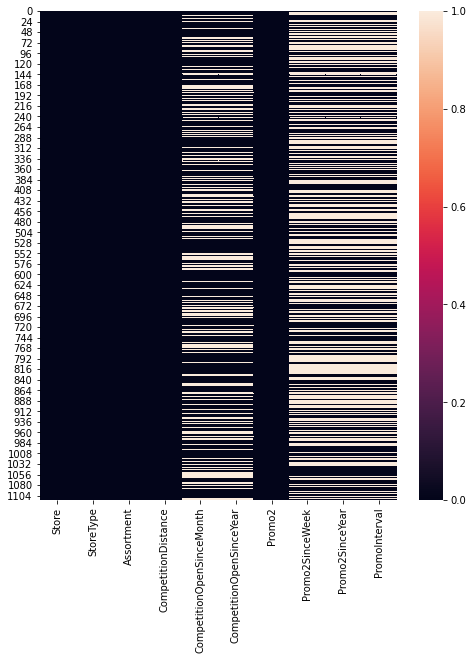

In [161]:
#Heatmap of missing values in the store_df 
plt.figure(figsize=(8,9))
sns.heatmap(missing_values)

In [162]:
store_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
store_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)
store_df['CompetitionDistance'].fillna(0,inplace=True)

In [163]:
# this features shows NaN values for all the stores which doesnt run promos and hence we substitute the value of Nan to 0
store_df['Promo2SinceWeek'].fillna(0,inplace=True)
store_df['Promo2SinceYear'].fillna(0,inplace=True)

In [164]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [165]:
# Converting Qualitative Values to Quantitative
def Promo_interval1(row):
  if (row['PromoInterval'] == 'Jan,Apr,Jul,Oct'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval2(row):
  if (row['PromoInterval'] == 'Feb,May,Aug,Nov'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval3(row):
  if (row['PromoInterval'] == 'Mar,Jun,Sept,Dec'):
    val = 1
  else:
    val = 0
  return val
def store_type(row):
  if (row['StoreType'] == 'a'):
    val = 1
  elif (row['StoreType'] == 'b'):
    val = 2
  elif (row['StoreType'] == 'c'):
    val = 3
  else:
    val = 4
  return val
def assortment_level(row):
  if (row['Assortment'] == 'a'):
    val = 1
  elif (row['Assortment'] == 'b'):
    val = 2
  else:
    val = 3
  return val

In [166]:
store_df['PromoInterval1'] = store_df.apply(Promo_interval1,axis=1)
store_df['PromoInterval2'] = store_df.apply(Promo_interval2,axis=1)
store_df['PromoInterval3'] = store_df.apply(Promo_interval3,axis=1)
store_df['Store_Type'] = store_df.apply(store_type,axis=1)
store_df['Assortment_Level'] = store_df.apply(assortment_level,axis=1)

In [167]:
store_df.drop(labels='PromoInterval',axis=1,inplace=True)
store_df.drop(labels='StoreType',axis=1,inplace=True)
store_df.drop(labels='Assortment',axis=1,inplace=True)

In [168]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   CompetitionDistance        1115 non-null   float64
 2   CompetitionOpenSinceMonth  1115 non-null   float64
 3   CompetitionOpenSinceYear   1115 non-null   float64
 4   Promo2                     1115 non-null   int64  
 5   Promo2SinceWeek            1115 non-null   float64
 6   Promo2SinceYear            1115 non-null   float64
 7   PromoInterval1             1115 non-null   int64  
 8   PromoInterval2             1115 non-null   int64  
 9   PromoInterval3             1115 non-null   int64  
 10  Store_Type                 1115 non-null   int64  
 11  Assortment_Level           1115 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 104.7 KB


In [169]:
store_df.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,Store_Type,Assortment_Level
0,1,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
1,2,570.0,11.0,2007.0,1,13.0,2010.0,1,0,0,1,1
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,1,0,0,1,1
3,4,620.0,9.0,2009.0,0,0.0,0.0,0,0,0,3,3
4,5,29910.0,4.0,2015.0,0,0.0,0.0,0,0,0,1,1


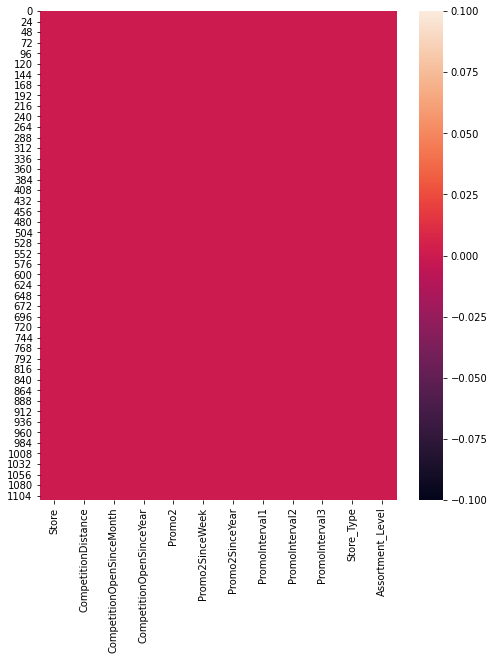

In [170]:
# The heatmap after filling all the NaN values
final_na_df= store_df.isnull()
plt.figure(figsize=(8,9))
sns.heatmap(final_na_df)

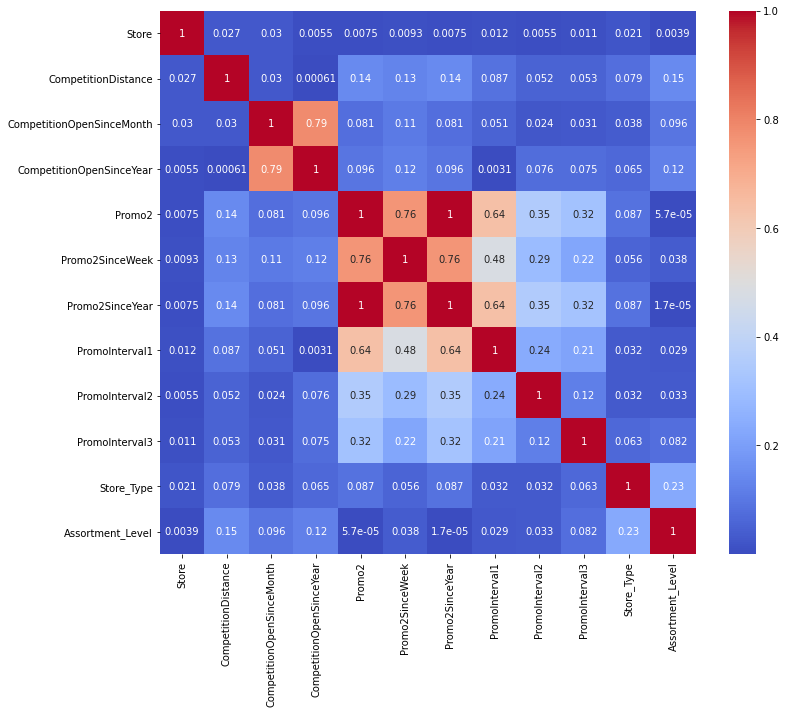

In [171]:
plt.figure(figsize=(12,10))
correlation = store_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [172]:
store_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [173]:
store_data_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Text(0.5, 0, '')

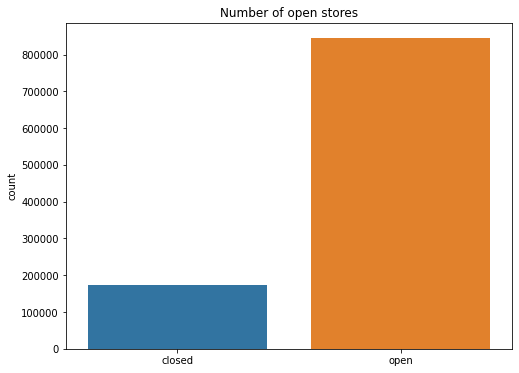

In [174]:
# number of stores open on a given day
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Open'])
count.set_title('Number of open stores')
count.set_xticklabels(['closed', 'open'])
count.set_xlabel('')

Text(0.5, 0, '')

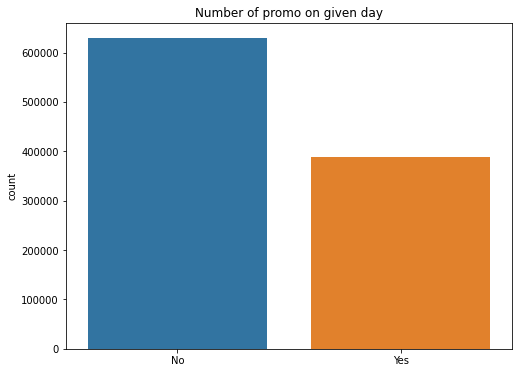

In [175]:
# number of promo 
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['Promo'])
count.set_title('Number of promo on given day')
count.set_xticklabels(['No', 'Yes'])
count.set_xlabel('')

Text(0.5, 0, '')

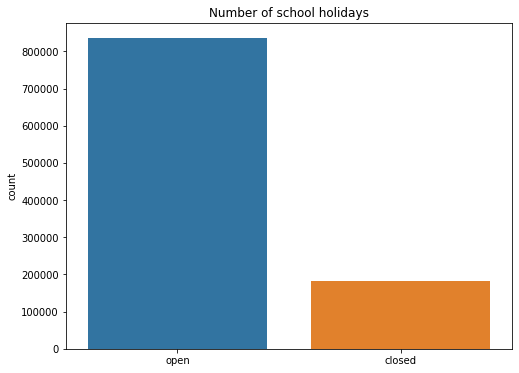

In [176]:
# number of school holiday
plt.figure(figsize=(8,6))
count = sns.countplot(x=store_data_df['SchoolHoliday'])
count.set_title('Number of school holidays')
count.set_xticklabels(['open', 'closed'])
count.set_xlabel('')

In [177]:
store_data_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [178]:
# convert StateHoliday to binary value features
# 1 indicates holiday and 0 indicates no holiday
store_data_df['public_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='a' else 0)
store_data_df['easter_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='b' else 0)
store_data_df['christmas'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='c' else 0)
store_data_df.drop(columns=['StateHoliday'], inplace=True)

In [179]:
store_data_df['public_holiday'].value_counts()

0    996949
1     20260
Name: public_holiday, dtype: int64

In [180]:
store_data_df['easter_holiday'].value_counts()

0    1010519
1       6690
Name: easter_holiday, dtype: int64

In [181]:
store_data_df['christmas'].value_counts()

0    1013109
1       4100
Name: christmas, dtype: int64

Text(0.5, 1.0, 'Number of Holidays celebrated by stores')

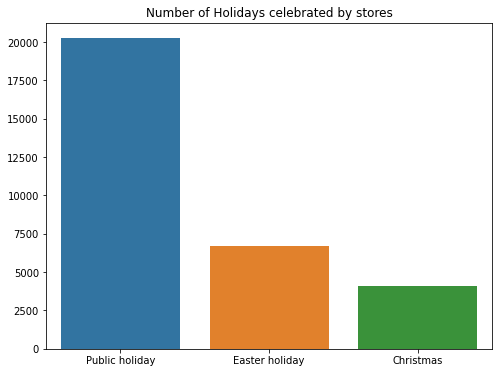

In [182]:
# plot number of holidays present in dataset
plt.figure(figsize=(8,6))
sns.barplot(x=['Public holiday','Easter holiday','Christmas'],
            y=[store_data_df['public_holiday'].value_counts()[1],store_data_df['easter_holiday'].value_counts()[1],store_data_df['christmas'].value_counts()[1]])
plt.title('Number of Holidays celebrated by stores')

Text(0.5, 1.0, 'Number of Stores data given by date')

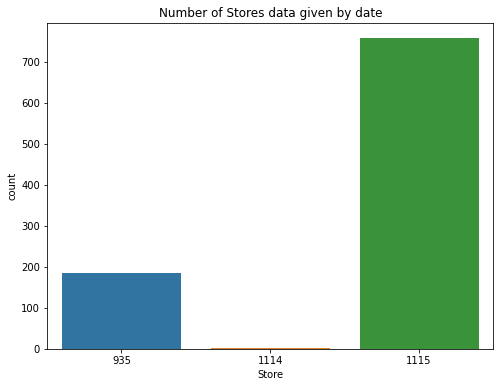

In [183]:
# count number of stores data given by date
plt.figure(figsize=(8,6))
sns.countplot(store_data_df.groupby(['Date'])['Store'].count())
plt.title('Number of Stores data given by date')

In [184]:
store_data_df.groupby(['Date'])['Store'].count().value_counts()

1115    757
935     184
1114      1
Name: Store, dtype: int64

Data for 170 stores is not given for 184 days 

We can assume that these stores are closed for refurbishment.

In [185]:
# changing date from string to integer values
def get_year(date):
  year = date[:4]
  return int(year)
def get_month(date):
  month = date[5:7]
  return int(month)
def get_day(date):
  day = date[8:]
  return int(day)

In [186]:
store_data_df['Year'] = store_data_df['Date'].apply(lambda x: get_year(x))
store_data_df['Month'] = store_data_df['Date'].apply(lambda x: get_month(x))
store_data_df['Day'] = store_data_df['Date'].apply(lambda x: get_day(x))
store_data_df.drop(columns=['Date'], inplace=True)

In [187]:
store_data_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31
1,2,5,6064,625,1,1,1,0,0,0,2015,7,31
2,3,5,8314,821,1,1,1,0,0,0,2015,7,31
3,4,5,13995,1498,1,1,1,0,0,0,2015,7,31
4,5,5,4822,559,1,1,1,0,0,0,2015,7,31


In [188]:
# checking senity of data
store_open_df = store_data_df.groupby(['Open']).sum()
store_open_df

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day
Open,,,,,,,,,,,,
0,96511898,1094583,0,0,11184,18264,19566,6545,4029,348024755,1011285,2601495
1,471527846,2972565,5873180623,644041755,376896,163457,694,145,71,1700463577,4936094,13371524


In [189]:
# calculate number of sstores open on holidays
store_holiday_df = store_open_df[['SchoolHoliday', 'public_holiday', 'easter_holiday', 'christmas']].reset_index()
store_holiday_df['Open'] = store_holiday_df['Open'].apply(lambda x: 'Open' if x==1 else 'Closed')
store_holiday_df

,Open,SchoolHoliday,public_holiday,easter_holiday,christmas
0,Closed,18264,19566,6545,4029
1,Open,163457,694,145,71


In [190]:
store_holiday_df= pd.melt(store_holiday_df, id_vars =['Open'])
store_holiday_df

,Open,variable,value
0,Closed,SchoolHoliday,18264
1,Open,SchoolHoliday,163457
2,Closed,public_holiday,19566
3,Open,public_holiday,694
4,Closed,easter_holiday,6545
5,Open,easter_holiday,145
6,Closed,christmas,4029
7,Open,christmas,71


Text(0.5, 1.0, 'Number of stores open on holidays')

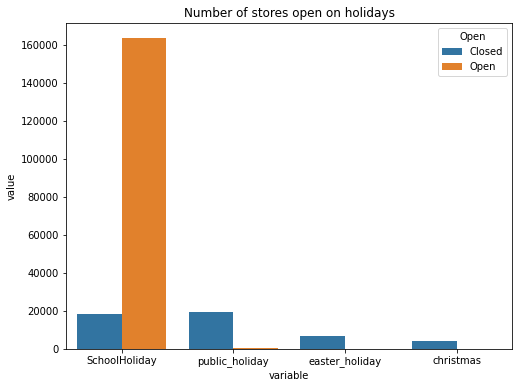

In [191]:
plt.figure(figsize=(8,6))
sns.barplot(x='variable',y='value',data=store_holiday_df,hue='Open')
plt.title('Number of stores open on holidays')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb950bba2d0>,
      dtype=object)

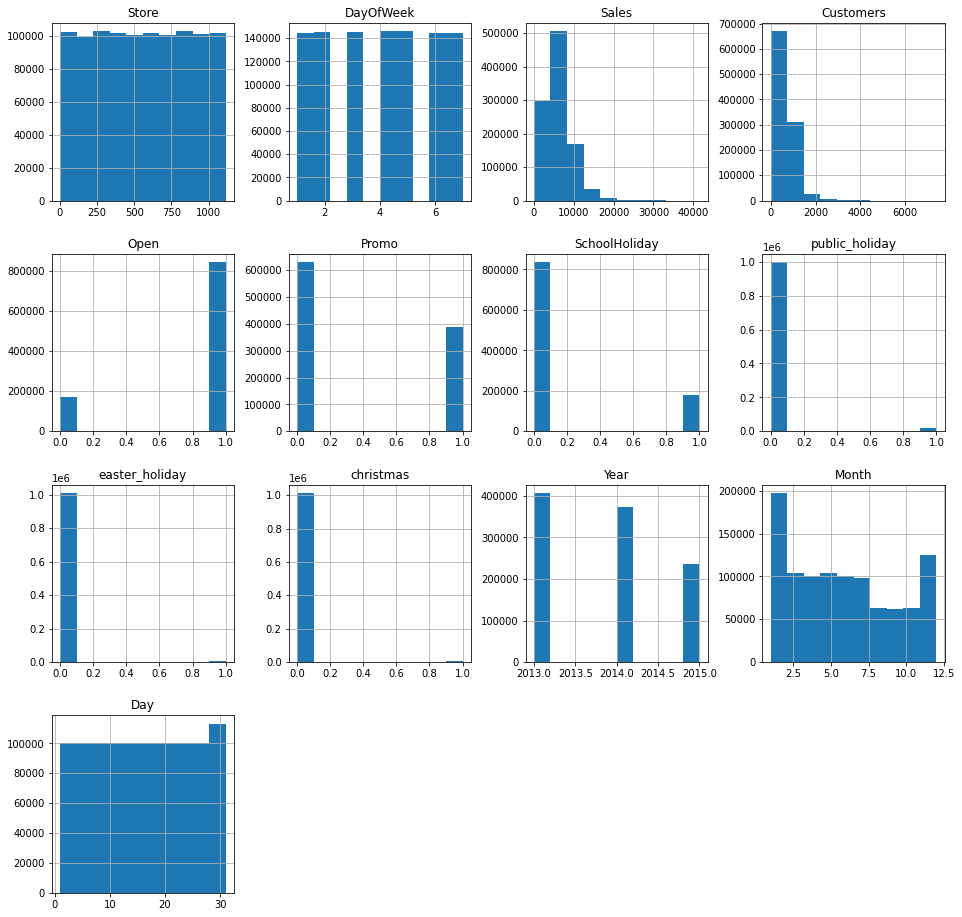

In [192]:
# plot the distribution of values
store_data_df.hist(figsize=(16,16))

In [193]:
# Log transforming features
store_data_df['Sales_log_t'] = store_data_df['Sales'].apply(lambda x: np.log(x+1))
store_data_df['Customers_log_t'] = store_data_df['Customers'].apply(lambda x: np.log(x+1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb95130ce50>,
      dtype=object)

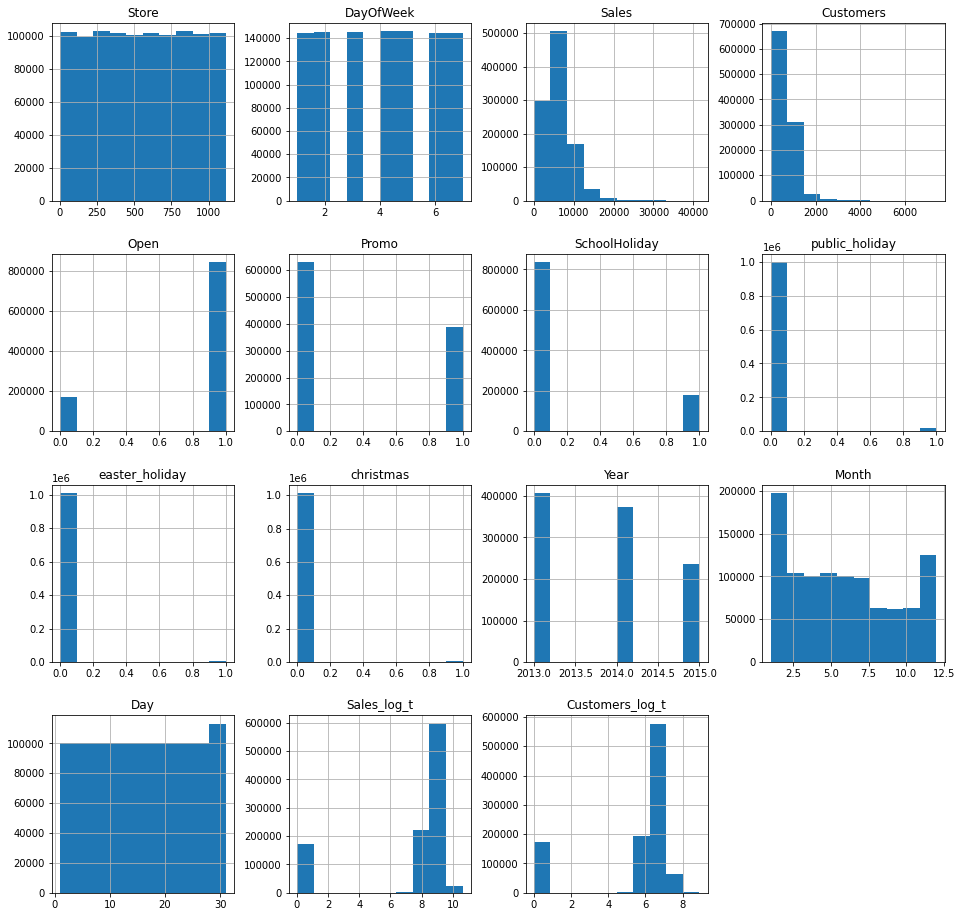

In [194]:
store_data_df.hist(figsize=(16,16))

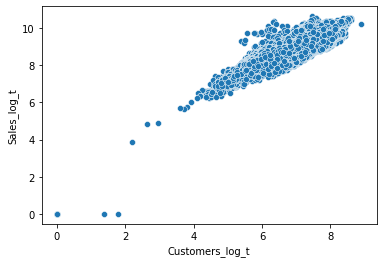

In [195]:
# plot relation between sales and customer
sns.scatterplot(data=store_data_df,x='Customers_log_t',y='Sales_log_t')

**Outlier Treatment**

Text(0.5, 1.0, 'Correlation matrix')

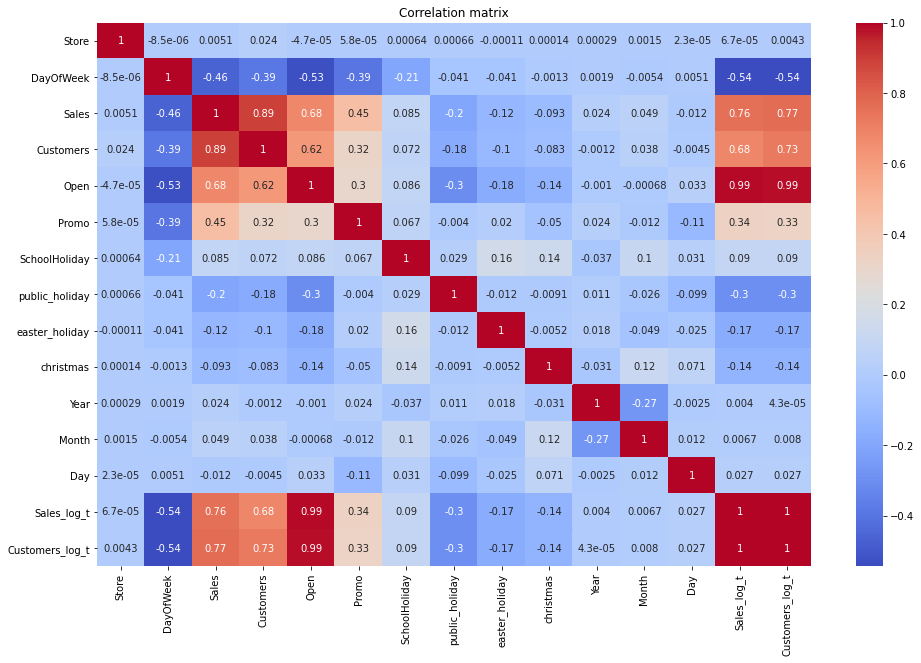

In [196]:
# plot correlation matrix
plt.figure(figsize=(16,10))
sns.heatmap(store_data_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

In [197]:
# merge datasets
sales_df = pd.merge(left=store_data_df, right=store_df, on='Store')
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,Store_Type,Assortment_Level
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,3,1


In [198]:
# updating promo2 for given date
def continuous_promotion(data):
  promo_month = False
  # promo2 is valid for stores that participate in continuous and consecutive promotion
  if data['Promo2'] == 1:
    # promotion should be running on current month
    current_month = data['Month']
    if ((current_month % 3 == 1) and (data['PromoInterval1'] == 1)):
      promo_month = True
    if ((current_month % 3 == 2) and (data['PromoInterval2'] == 1)):
      promo_month = True
    if ((current_month % 3 == 0) and (data['PromoInterval3'] == 1)):
      promo_month = True
    # if current moth is promo month then promotion should start before current date
    if promo_month:
      if (data['Year'] > data['Promo2SinceYear']):
        # promo2 start before current year
        return 1
      if (data['Year'] == data['Promo2SinceYear']):
        # promo2 start on this year
        if (current_month > ((data['Promo2SinceWeek']//4)+1)):
          # promo2 start before current month
          return 1
  return 0

In [199]:
# combine features for promo2
sales_df['Promo_cont'] = sales_df.apply(continuous_promotion, axis=1)

In [200]:
# remove columns
sales_df.drop(columns=['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'], inplace=True)

In [201]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store_Type,Assortment_Level,Promo_cont
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,9.0,2008.0,3,1,0
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,9.0,2008.0,3,1,0
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,9.0,2008.0,3,1,0
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,9.0,2008.0,3,1,0
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,9.0,2008.0,3,1,0


In [202]:
# removing the collinearity by converting to quantitative data of CompetitionOpenSinceYear and CompetitionOpenSinceMonth
def CompitionOpenTimeInDays(row):
  # check if competition exist
  if row['CompetitionOpenSinceYear'] == 0:
    return 0
  compitition_start_date = date(int(row['CompetitionOpenSinceYear']),int(row['CompetitionOpenSinceMonth']),1) # add 1 as day indicating start of month
  competetion_time = date(int(row['Year']), int(row['Month']), int(row['Day'])) - compitition_start_date
  # check if competition time exist
  if competetion_time.days <= 0:
    return 0
  return competetion_time.days

In [203]:
sales_df['CompitionTime']=sales_df.apply(CompitionOpenTimeInDays,axis=1)

In [204]:
sales_df.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],inplace=True)

In [205]:
sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
1,1,4,5020,546,1,1,1,0,0,0,2015,7,30,8.521384,6.304449,1270.0,3,1,0,2523
2,1,3,4782,523,1,1,1,0,0,0,2015,7,29,8.472823,6.261492,1270.0,3,1,0,2522
3,1,2,5011,560,1,1,1,0,0,0,2015,7,28,8.519590,6.329721,1270.0,3,1,0,2521
4,1,1,6102,612,1,1,1,0,0,0,2015,7,27,8.716536,6.418365,1270.0,3,1,0,2520


Text(0.5, 1.0, 'Correlation matrix')

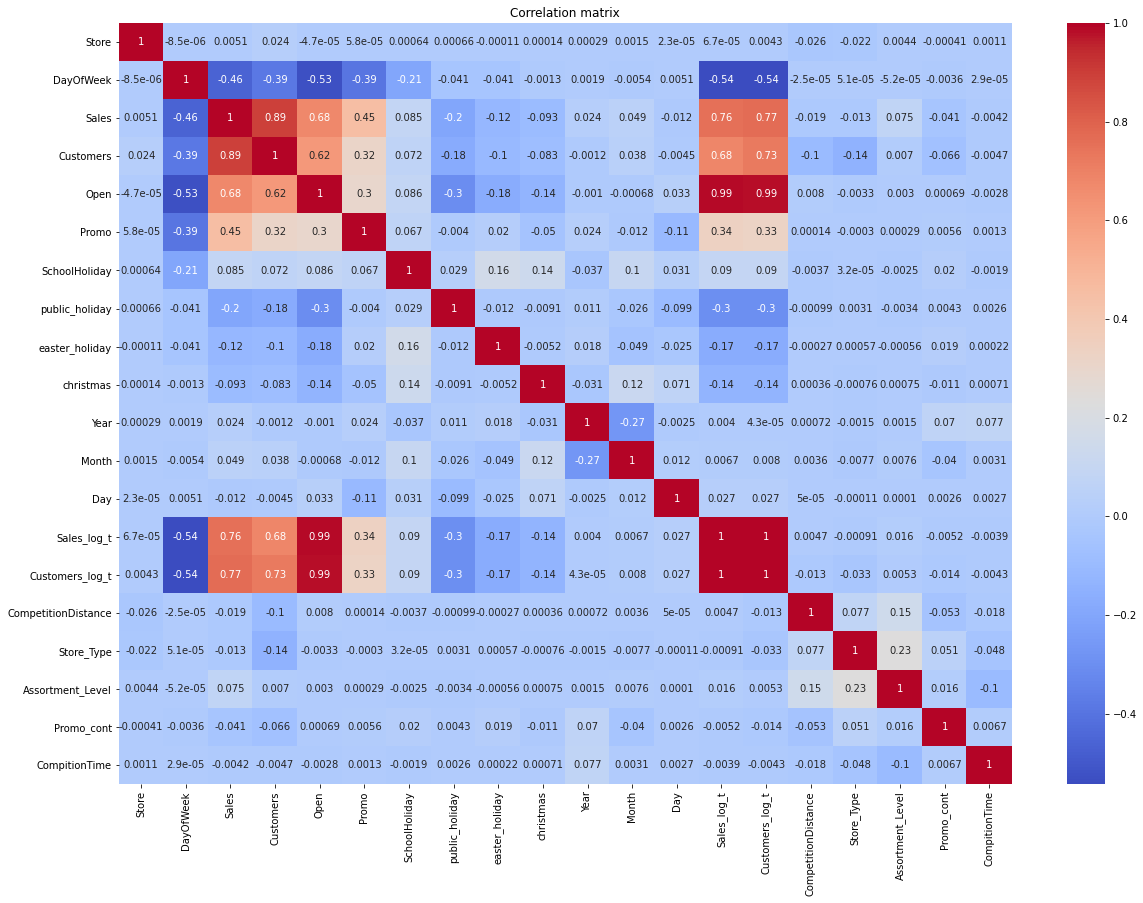

In [206]:
# plot correlation matrix
plt.figure(figsize=(20,14))
sns.heatmap(sales_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

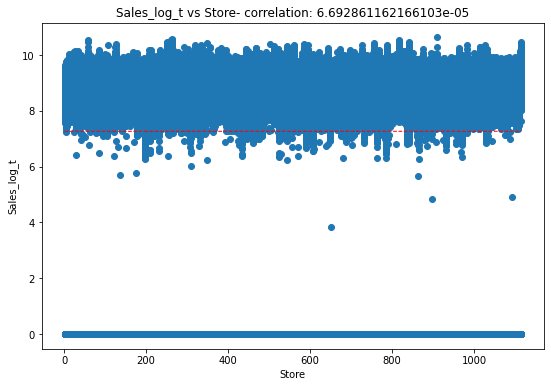

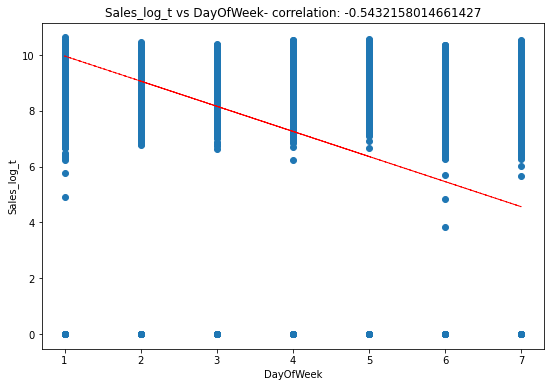

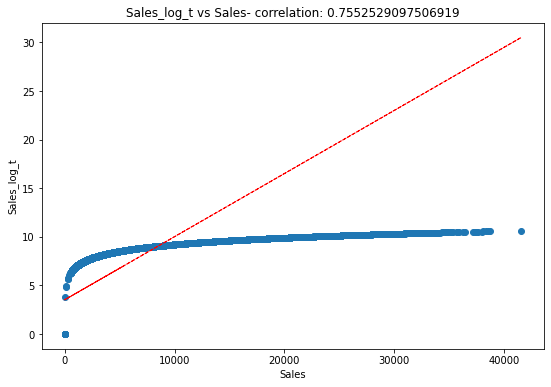

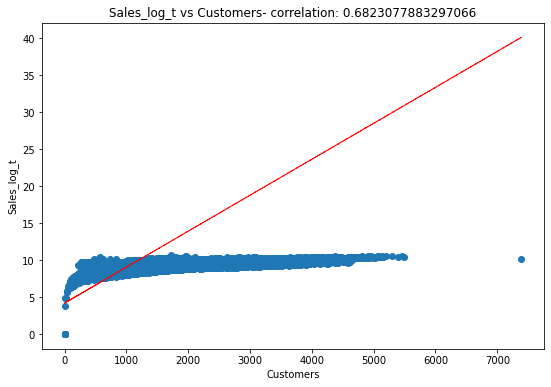

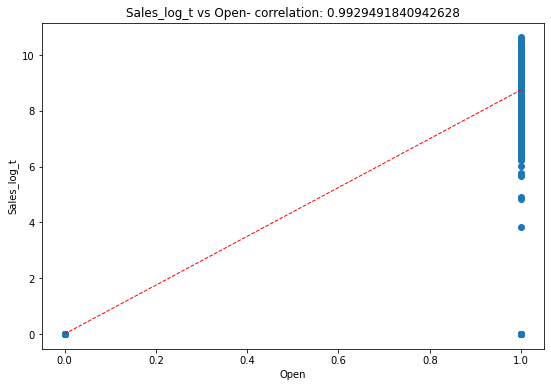

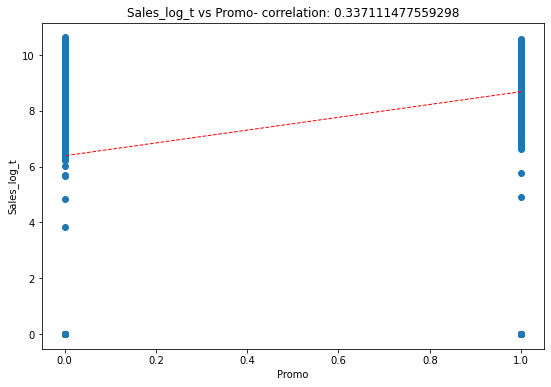

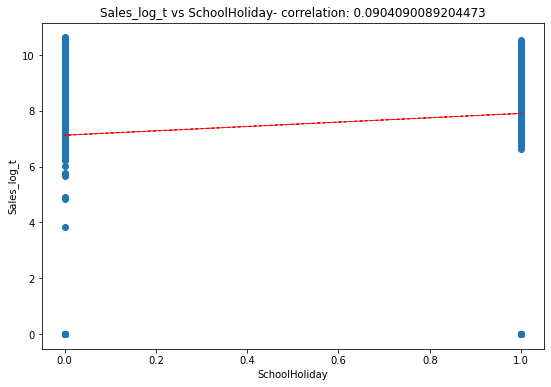

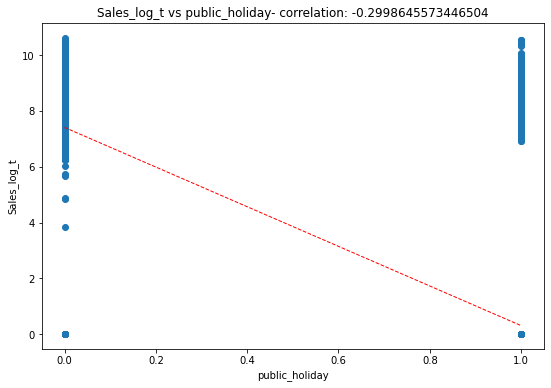

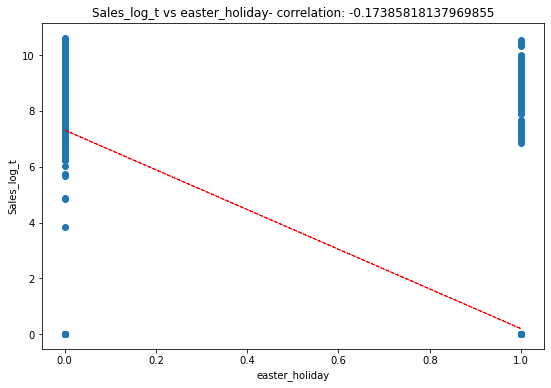

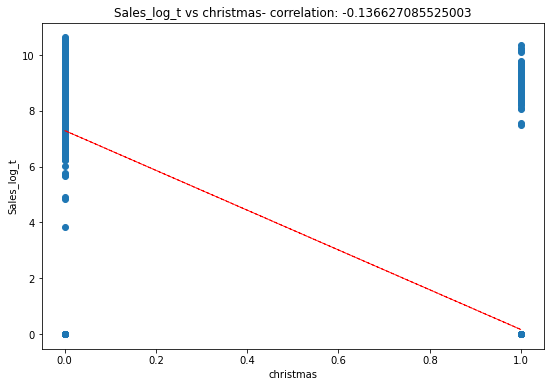

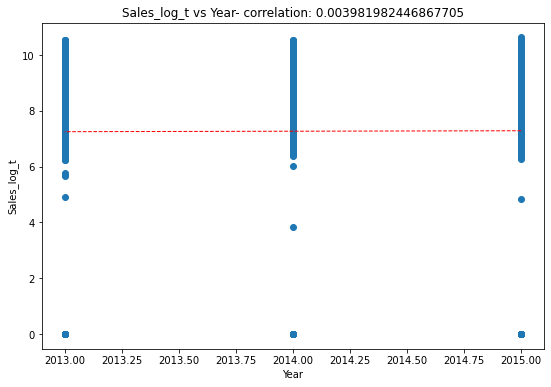

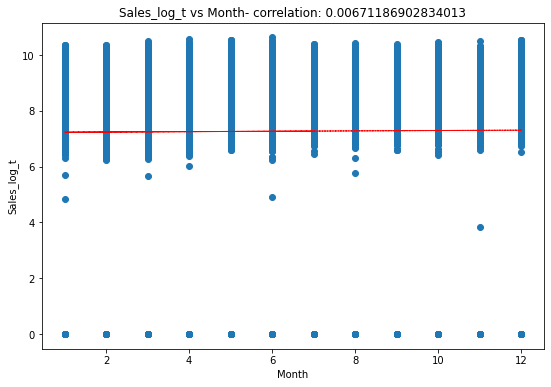

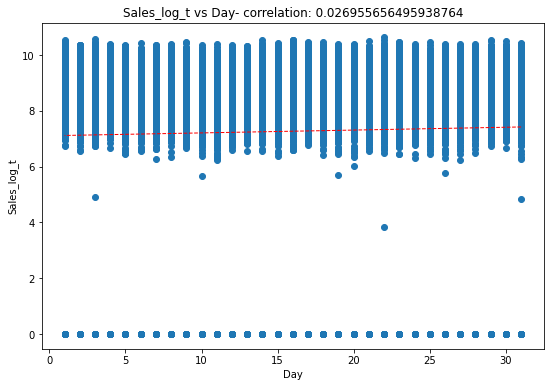

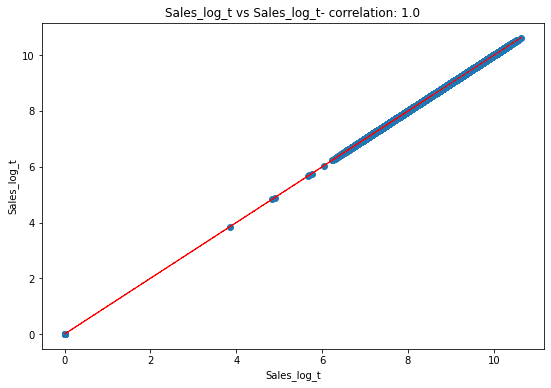

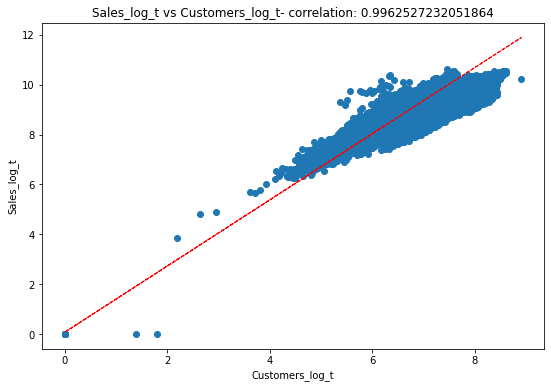

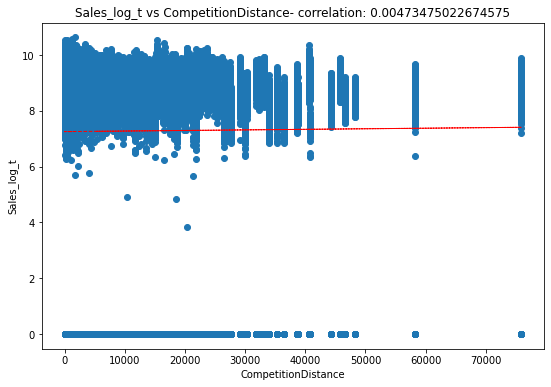

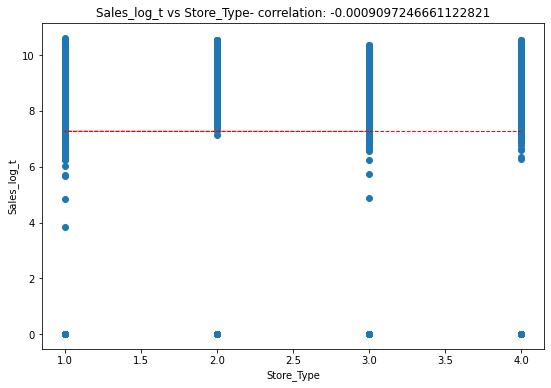

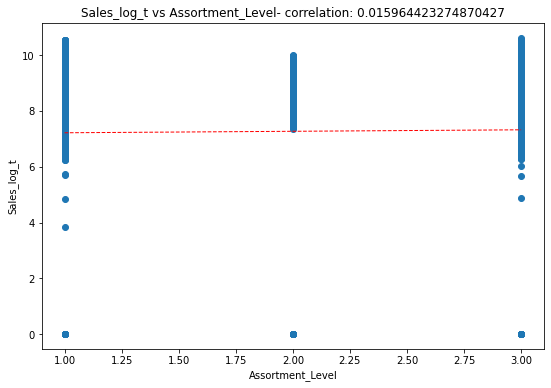

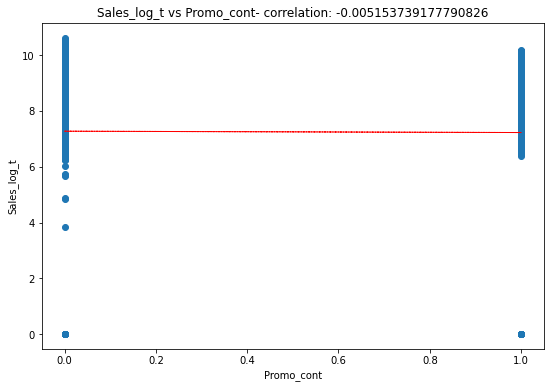

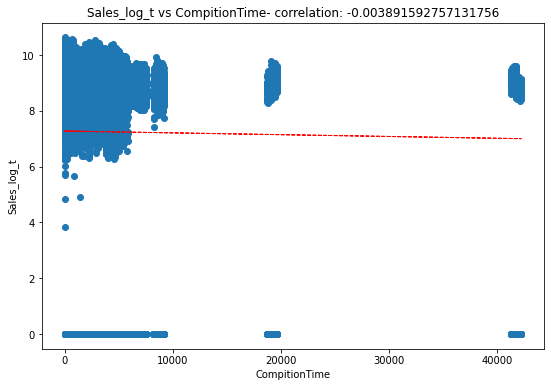

In [207]:
for col in sales_df:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = sales_df[col]
    label = sales_df['Sales_log_t']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales_log_t')
    ax.set_title('Sales_log_t vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(sales_df[col], sales_df['Sales_log_t'], 1)
    y_hat = np.poly1d(z)(sales_df[col])

    plt.plot(sales_df[col], y_hat, "r--", lw=1)

plt.show()

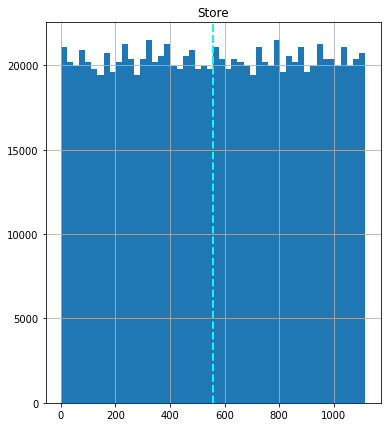

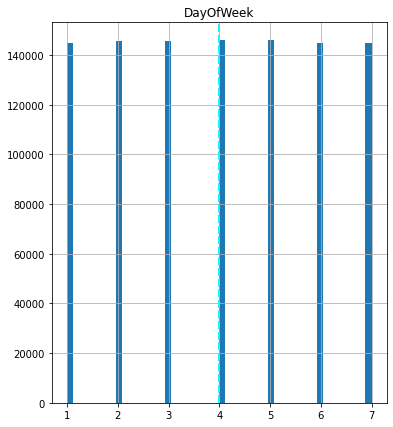

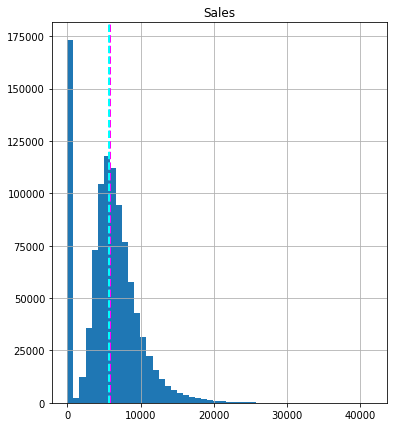

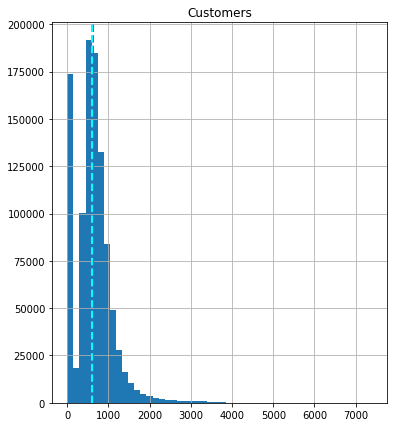

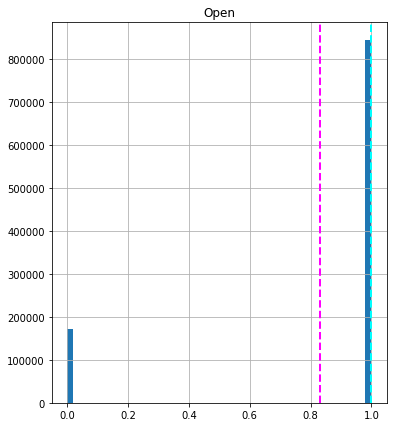

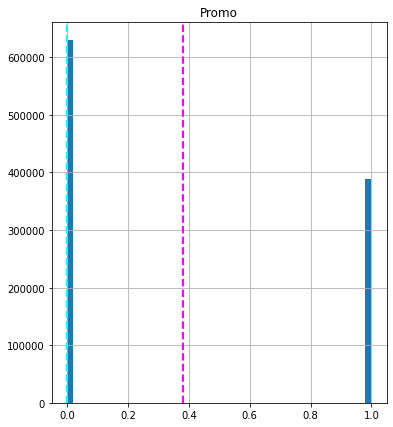

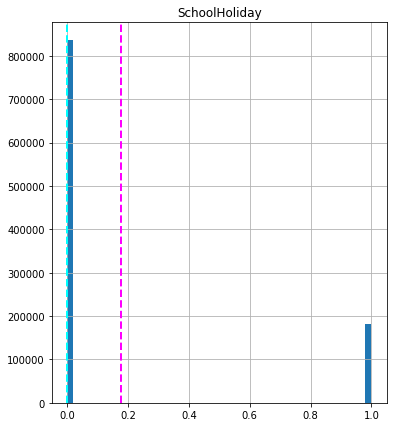

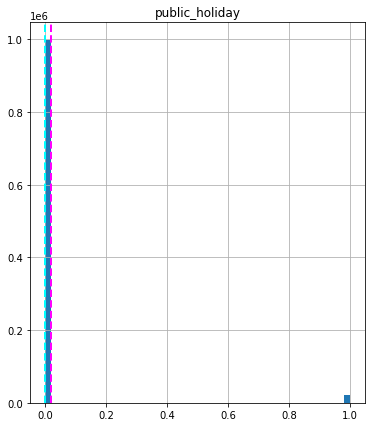

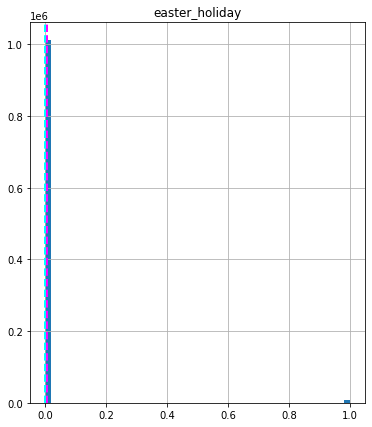

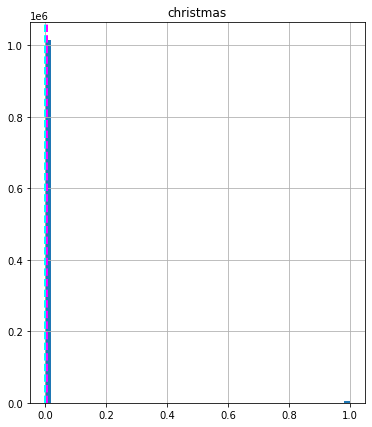

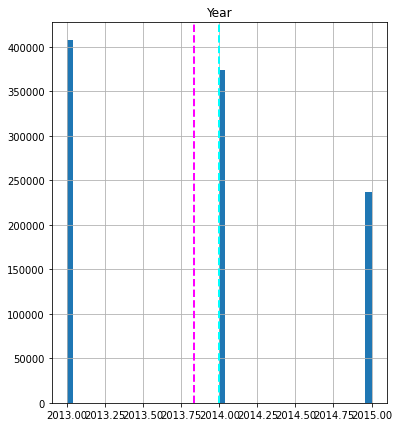

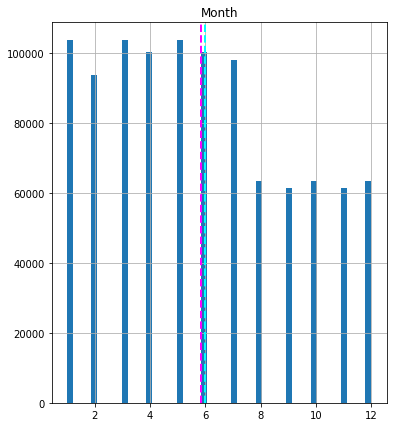

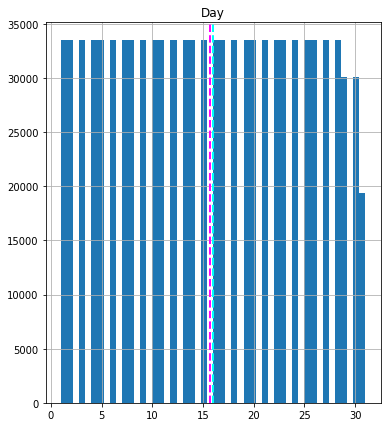

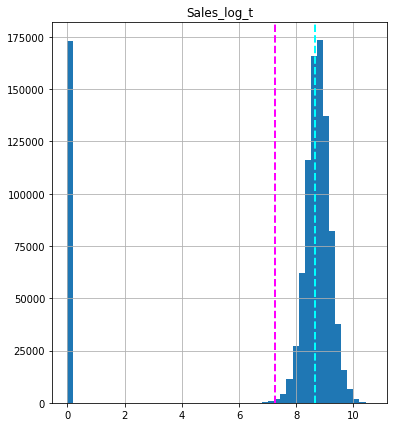

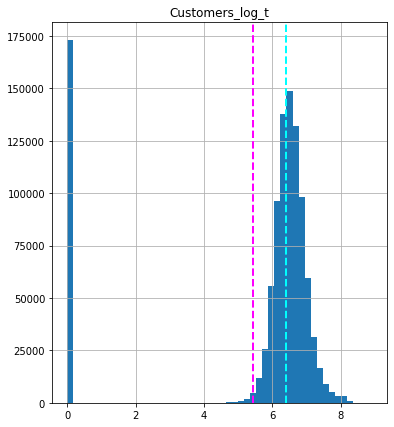

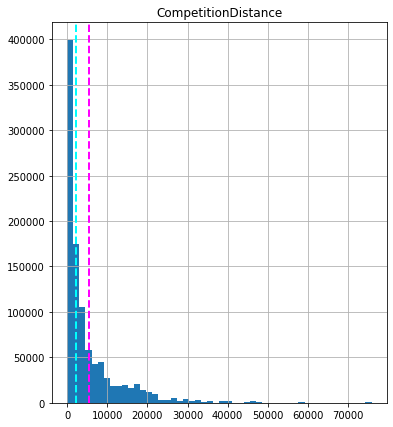

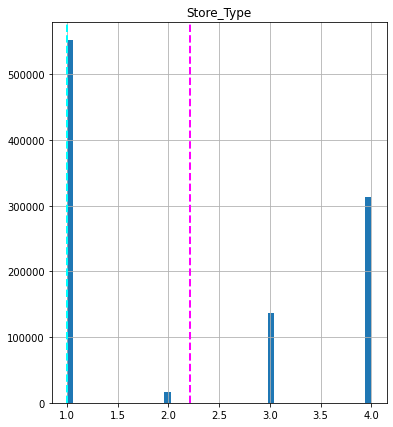

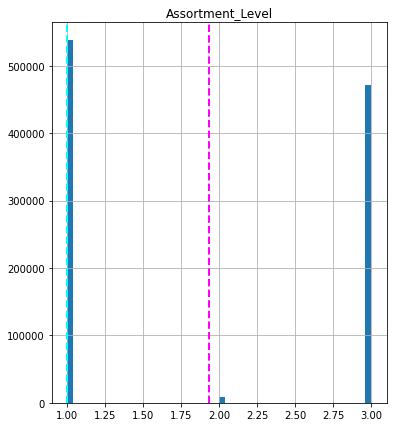

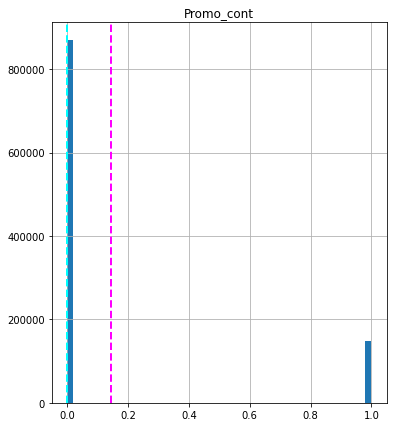

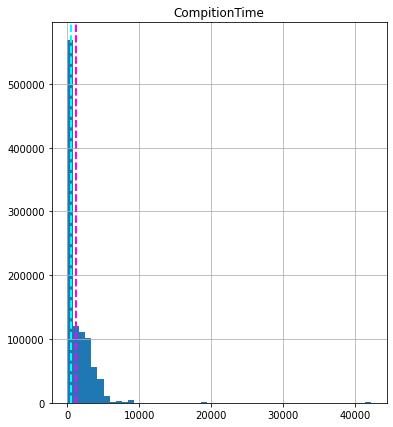

In [208]:
for col in sales_df:
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = sales_df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

**Removing Multicollinearity**

In [209]:
# function to calculate VIF
def calculate_vif(data):
  vif = pd.DataFrame()
  vif["variables"] = data.columns
  vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif

In [210]:
calculate_vif(sales_df.drop(columns=['Sales','Customers','Year','Sales_log_t', 'Customers_log_t']))

,variables,VIF
0,Store,3.730827
1,DayOfWeek,4.452981
2,Open,6.191915
3,Promo,1.872410
4,SchoolHoliday,1.342025
5,public_holiday,1.099311
6,easter_holiday,1.074031
7,christmas,1.072576
8,Month,3.904310
9,Day,3.965944


#2. Model Building

split the data by date to test the model predictions

In [211]:
# split the dataset in 2 by dates, for test on last 6 weeks
sorted_sales_df = sales_df.sort_values(by=['Year','Month','Day'],ascending=False)
sorted_sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
942,2,5,6064,625,1,1,1,0,0,0,2015,7,31,8.710290,6.439350,570.0,1,1,1,2829
1884,3,5,8314,821,1,1,1,0,0,0,2015,7,31,9.025816,6.711740,14130.0,1,1,1,3164
2826,4,5,13995,1498,1,1,1,0,0,0,2015,7,31,9.546527,7.312553,620.0,3,3,0,2159
3768,5,5,4822,559,1,1,1,0,0,0,2015,7,31,8.481151,6.327937,29910.0,1,1,0,121


In [212]:
# get split date
last_date = date(int(sorted_sales_df.iloc[0]['Year']),int(sorted_sales_df.iloc[0]['Month']),int(sorted_sales_df.iloc[0]['Day']))
split_date = last_date - timedelta(6*7) # remove 6 weeks from last date of data
split_date 

datetime.date(2015, 6, 19)

In [213]:
# find index of split date
index = 0
for i in range(len(sorted_sales_df)):
  year = int(sorted_sales_df.iloc[i]['Year'])
  month = int(sorted_sales_df.iloc[i]['Month'])
  day = int(sorted_sales_df.iloc[i]['Day'])
  if ((year == split_date.year) and (month == split_date.month) and (day == split_date.day)):
    index = i
    break
print(index)

46830


In [214]:
test_data = sorted_sales_df.iloc[:46830].sample(frac = 1)
train_data = sorted_sales_df.iloc[46830:].sample(frac = 1)
print(train_data.shape, test_data.shape)

(970379, 20) (46830, 20)


In [215]:
dependent_variable = 'Sales_log_t'

In [216]:
# Create a list of independent variables
independent_variables = list(set(sales_df.columns.tolist()) - {'Customers_log_t','Sales','Customers','Year','Sales_log_t'})
independent_variables

['Month',
 'Promo',
 'christmas',
 'Store',
 'public_holiday',
 'SchoolHoliday',
 'Assortment_Level',
 'CompetitionDistance',
 'Open',
 'Promo_cont',
 'Store_Type',
 'easter_holiday',
 'CompitionTime',
 'DayOfWeek',
 'Day']

In [217]:
X_train = train_data[independent_variables].values
X_test = test_data[independent_variables].values
y_train = train_data[dependent_variable].values
y_test = test_data[dependent_variable].values

In [218]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [219]:
X_train[0:10]

array([[5.45454545e-01, 1.00000000e+00, 0.00000000e+00, 6.44524237e-01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.07962035e-01,
        1.00000000e+00, 0.00000000e+00, 6.66666667e-01, 0.00000000e+00,
        0.00000000e+00, 6.66666667e-01, 1.33333333e-01],
       [6.36363636e-01, 0.00000000e+00, 0.00000000e+00, 8.44703770e-01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.04297390e-02,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.66666667e-01, 6.33333333e-01],
       [8.18181818e-01, 1.00000000e+00, 0.00000000e+00, 6.03231598e-01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.99973636e-01,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.66666667e-01, 8.00000000e-01],
       [2.72727273e-01, 0.00000000e+00, 0.00000000e+00, 3.58168761e-01,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 9.22752439e-04,
        1.00000000e+00, 1.00000000e+0

## Building linear regression model

In [220]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [221]:
regressor.intercept_

0.07188030354881914

In [222]:
regressor.coef_

array([ 7.73650058e-02,  3.12333760e-01, -1.07104519e-01, -7.61056417e-04,
       -1.74944079e-01,  1.69162209e-02,  9.11216817e-02, -1.82370512e-01,
        8.54828291e+00, -5.99519711e-02, -1.41869309e-03, -2.23372755e-01,
        7.86539605e-03, -1.22838333e-01, -1.79895719e-02])

In [223]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

**Model Evaluation**

In [224]:
# Function to check for Evaluation Metrics
def mean_absolute_percentage_error(actual, pred):
  error_term = actual - pred
  num_of_observation = len(error_term)
  sum = 0
  for i in range(num_of_observation):
    if actual[i] != 0:
      sum = sum + abs(error_term[i]/actual[i])
    else:
      sum = sum + abs(error_term[i])
  return sum*100/num_of_observation

def evaluation_metrics(actual, pred, num_of_features=0):
  MSE = mean_squared_error (actual , pred)
  print('Mean Squared Error :' , round(MSE,2))
  print('Root Mean Squared Error :' , round(np.sqrt(MSE)))
  error_term = actual - pred
  num_of_observation = len(error_term)
  MAE = sum(abs(error_term))/num_of_observation
  print('Mean Absolute Error :' , round(MAE,2))
  print('Mean Absolute Percentage Error :' , round(mean_absolute_percentage_error(actual, pred),2), '%')
  R2 = r2_score(y_test , y_pred)
  print('R-Square :' , round(R2,2)) 
  if num_of_features > 0:
    adj_r2 = 1-(1-R2)*((num_of_observation-1)/(num_of_observation-num_of_features-1))
    print("Adjusted R-Square : ", round(adj_r2, 2))

In [225]:
# Evaluating Linear Reegression model
evaluation_metrics(y_test , y_pred, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


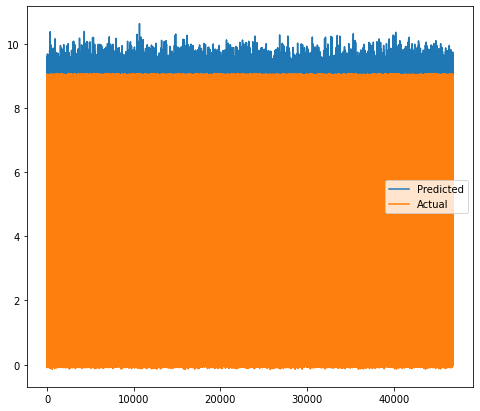

In [226]:
#Plot between actual and predicted
plt.figure(figsize=(8,7))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(["Predicted" , "Actual"])
plt.show()

**Checking the assumptions of Linear Regression**

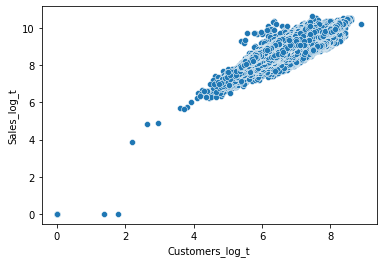

In [227]:
# Plotting the relationship between sales and customer
sns.scatterplot(data=sales_df,x='Customers_log_t',y='Sales_log_t')

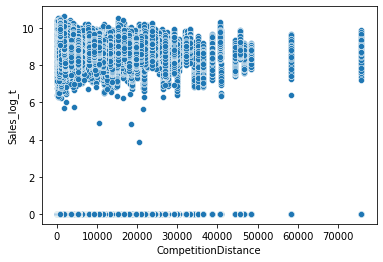

In [228]:
# Plotting the relationship between Sales and Competition Distance
sns.scatterplot(data=sales_df,x='CompetitionDistance',y='Sales_log_t')

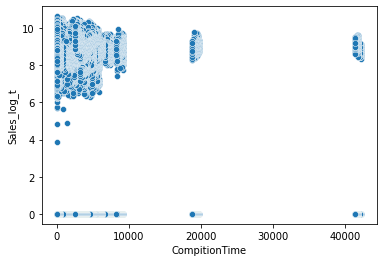

In [229]:
# Plotting the relationship between Sales and Compition Open Since Number Of Days
sns.scatterplot(data=sales_df,x='CompitionTime',y='Sales_log_t')

In [230]:
# Checking the mean of Residuals
sum(y_pred-y_test)/ len(sales_df)

-0.0007064634619244308

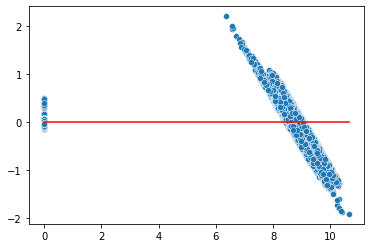

In [231]:
# Checking Homoscedasticity
error_terms = y_pred-y_test
plot = sns.scatterplot(x=y_test,y=error_terms)
# plot.map_dataframe(plot_hline,y=0)
plt.plot([0,max(y_test)], [0,0], 'r-')

**Regularization**

**Implementing Lasso Regression**

In [232]:
lasso = Lasso(alpha = 0.1 , max_iter = 3000)
lasso.fit(X_train , y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [233]:
lasso.score(X_train , y_train)

0.9801265433011739

In [234]:
y_pred_lasso = lasso.predict(X_test)

In [235]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, len(independent_variables))

Mean Squared Error : 0.2
Root Mean Squared Error : 0
Mean Absolute Error : 0.37
Mean Absolute Percentage Error : 11.38 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Running Grid Search Cross Validation for Lasso Regression**

In [236]:
#cross validation
lasso = Lasso()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
lasso_regressor = GridSearchCV(lasso , parameters , scoring='neg_mean_squared_error' , cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [237]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}

Using  {'alpha': 1e-08}  the negative mean squared error is:  -0.1266061281152239


In [238]:
y_pred_lasso = lasso_regressor.predict(X_test)

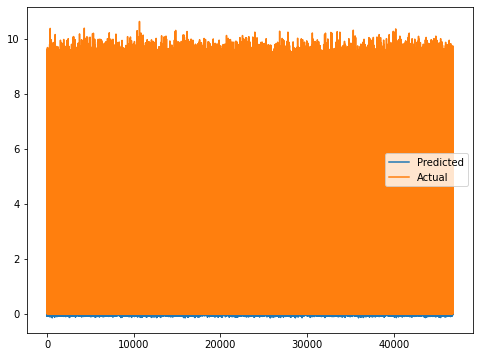

In [239]:
plt.figure(figsize=(8,6))
plt.plot(y_pred_lasso)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [240]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, X_test.shape[1])

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Implementing Ridge Regression**

In [241]:
ridge  = Ridge(alpha=0.1)

In [242]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [243]:
ridge.score(X_train, y_train)

0.9885345334700549

In [244]:
y_pred_ridge = ridge.predict(X_test)

In [245]:
#Evaluation metrics for Ridge Regression
evaluation_metrics(y_test , y_pred_ridge, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Running Grid Search Cross Validation for Ridge Regression**

In [246]:
#cross validation
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
ridge_regressor = GridSearchCV(ridge , parameters , scoring='neg_mean_squared_error' , cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [247]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  -0.1266061281156295


In [248]:
#Model Prediction
y_pred_ridge = ridge_regressor.predict(X_test)

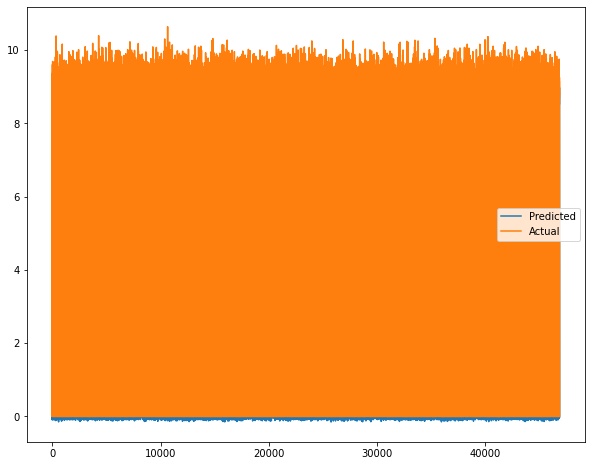

In [249]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_ridge)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [250]:
#Evaluation metrics for Ridge Regression
evaluation_metrics(y_test , y_pred_ridge, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Implementing Elastic net Regression**

In [251]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [252]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [253]:
elasticnet.score(X_train, y_train)

0.9093241801679223

In [254]:
y_pred_en = elasticnet.predict(X_test)

In [255]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en, len(independent_variables))

Mean Squared Error : 0.8
Root Mean Squared Error : 1
Mean Absolute Error : 0.68
Mean Absolute Percentage Error : 30.75 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Running Grid Search Cross Validation for Elastic Net Regression**

In [256]:
#cross validation
elastic = ElasticNet()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
elastic_regressor = GridSearchCV(elastic , parameters , scoring='neg_mean_squared_error' , cv=5)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [257]:
y_pred_en = elastic_regressor.predict(X_test)

In [258]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}

Using  {'alpha': 1e-08}  the negative mean squared error is:  -0.12660612811374733


In [259]:
#Model Prediction
y_pred_en = elastic_regressor.predict(X_test)

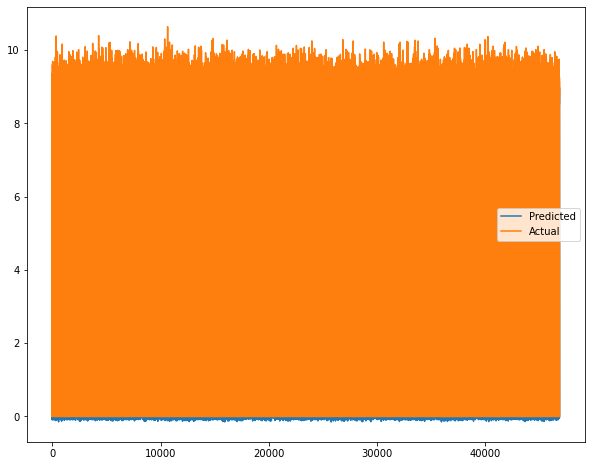

In [260]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_en)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [261]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Predicting Sales for next six weeks**

In [262]:
test_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompitionTime
910532,999,6,5489,421,1,0,0,0,0,0,2015,6,20,8.610684,6.045005,15140.0,4,3,0,4887
417086,458,2,5526,552,1,0,0,0,0,0,2015,7,7,8.617400,6.315358,3390.0,3,1,0,0
224429,248,5,6926,968,1,0,0,0,0,0,2015,6,26,8.843182,6.876265,340.0,1,3,0,1028
932184,1023,7,0,0,0,0,0,0,0,0,2015,7,26,0.000000,0.000000,3740.0,3,1,1,4923
263283,291,1,6963,750,1,0,0,0,0,0,2015,6,22,8.848509,6.621406,0.0,4,1,0,0


In [263]:
#Creating new dataframe
new_df = pd.DataFrame()

In [264]:
#Creating stores list for our new dataframe using for loop
store_list = []
for i in range(1, 1116):
  store_list.append(i)


In [265]:
#Adding the column Stores in our new dataframe
new_df['Stores'] = store_list

In [266]:
day = date(2015 , 6 , 20)

In [267]:
day.weekday()  

5

In [268]:
day+timedelta(1)

datetime.date(2015, 6, 21)

In [269]:
#Creating date for next six weeks for new dataframe
date_time = []
for i in range(1, 43):
  date_time.append(day+timedelta(i))


In [270]:
date_time[:10]

[datetime.date(2015, 6, 21),
 datetime.date(2015, 6, 22),
 datetime.date(2015, 6, 23),
 datetime.date(2015, 6, 24),
 datetime.date(2015, 6, 25),
 datetime.date(2015, 6, 26),
 datetime.date(2015, 6, 27),
 datetime.date(2015, 6, 28),
 datetime.date(2015, 6, 29),
 datetime.date(2015, 6, 30)]

In [271]:
new_store = []
new_date = []
for i in range(1, 1116):
  for j in range(1, 43):
    new_store.append(i)
    new_date.append(day+timedelta(j))


In [272]:
new_df_1 = pd.DataFrame()
new_df_1["Stores"] = new_store

In [273]:
new_df_1["Date_time"] = new_date

In [274]:
new_df_1.head()

,Stores,Date_time
0,1,2015-06-21
1,1,2015-06-22
2,1,2015-06-23
3,1,2015-06-24
4,1,2015-06-25


In [275]:
new_df_1.tail()

,Stores,Date_time
46825,1115,2015-07-28
46826,1115,2015-07-29
46827,1115,2015-07-30
46828,1115,2015-07-31
46829,1115,2015-08-01


In [276]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompitionTime
654296,719,5,6541,526,1,1,0,0,0,0,2013,7,5,8.785998,6.267201,8190.0,3,3,0,0
858244,942,2,4682,422,1,0,0,0,0,0,2013,8,20,8.451694,6.047372,6860.0,4,3,0,0
612876,673,5,6828,555,1,1,0,0,0,0,2013,10,25,8.828934,6.320768,15170.0,4,3,0,0
364729,400,4,7249,1149,1,0,1,0,0,0,2014,4,24,8.888757,7.047517,70.0,1,1,1,3461
18973,21,1,8349,714,1,1,0,0,0,0,2014,3,17,9.030017,6.572283,550.0,3,3,0,5281


In [277]:
new_df_1["DayOfWeek"] = new_df_1['Date_time'].apply(lambda x: x.weekday()+1)


In [ ]:
new_df_1

In [279]:
new_df_1['Open'] =0

In [280]:
new_df_1['promo']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['Promo'])

In [281]:
new_df_1['School_holiday']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['SchoolHoliday'])

In [282]:
new_df_1['Public_holiday']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['public_holiday'])

In [283]:
new_df_1['Easter_holiday']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['easter_holiday'])

In [284]:
new_df_1['year']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['Year'])

In [285]:
new_df_1['month']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['Month'])

In [286]:
new_df_1['day']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['Day'])

In [291]:
new_df_1['Competition_Distance']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['CompetitionDistance'])

In [292]:
new_df_1['promo_cont']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['Promo_cont'])

In [293]:
new_df_1['Compition_Time']= new_df_1['Stores'].apply(lambda x: train_data[train_data['Store'] == x].iloc[0]['CompitionTime'])

In [294]:
new_df_1

,Stores,Date_time,DayOfWeek,Open,promo,School_holiday,Public_holiday,Easter_holiday,year,month,day,Competition_Distance,promo_cont,Compition_Time
0,1,2015-06-21,7,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
1,1,2015-06-22,1,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
2,1,2015-06-23,2,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
3,1,2015-06-24,3,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
4,1,2015-06-25,4,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2015-07-28,2,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46826,1115,2015-07-29,3,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46827,1115,2015-07-30,4,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46828,1115,2015-07-31,5,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0


In [295]:
new_df_1.drop(['Date_time'] , axis=1)

,Stores,DayOfWeek,Open,promo,School_holiday,Public_holiday,Easter_holiday,year,month,day,Competition_Distance,promo_cont,Compition_Time
0,1,7,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
1,1,1,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
2,1,2,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
3,1,3,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
4,1,4,0,1.0,0.0,0.0,0.0,2013.0,9.0,26.0,1270.0,0.0,1851.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46826,1115,3,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46827,1115,4,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
46828,1115,5,0,0.0,0.0,0.0,0.0,2013.0,6.0,10.0,5350.0,1.0,0.0
